# Estudi Spectral Clustering amb Modificacions

## Utilització GridSearch

In [2]:
import pandas as pd

In [3]:
#Llegim fitxer

df_students = pd.read_csv("datasets/Data Carrard.csv")
df_students = df_students.drop('id', axis = 1)

df_categorical = df_students[['sex', 'year', 'glang', 'part', 'job', 'stud_h', 'health', 'psyt']]
df_numerical = df_students[['age', 'jspe', 'qcae_cog', 'qcae_aff', 'amsp', 'erec_mean', 'cesd', 'stai_t', 'mbi_ex', 'mbi_cy', 'mbi_ea']]

In [4]:
def sampleig_dataset(dataset, frac):
    dataset = dataset.sample(frac=frac).reset_index(drop=True)
    return dataset

In [5]:
frac_train = 0.7
frac_test = 0.3

X_train = sampleig_dataset(df_students, frac_train)
X_test = sampleig_dataset(df_students, frac_test)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
df_num_scaled = scaler.fit_transform(df_numerical)

# Create a PCA instance: pca
pca = PCA(n_components=0.95)

# Fit the PCA instance to the scaled samples
pca.fit(df_num_scaled)

# Transform the scaled samples: pca_features
pca_features = pca.transform(df_num_scaled)

## Busquem millor model

In [7]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

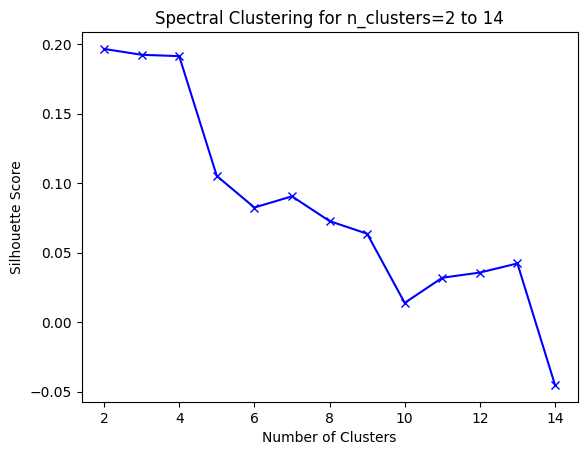

In [20]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def elbow_report_spectral(X):
    silhouette_scores = []
    n_clusters_range = range(2, 15)
    
    for n_clusters in n_clusters_range:
        model_sc = SpectralClustering(n_clusters=n_clusters, random_state=42)
        clusters = model_sc.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, clusters))
        
    plt.plot(n_clusters_range, silhouette_scores, 'bx-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Spectral Clustering for n_clusters=2 to 14')
    plt.show()

# Aplicar la función al conjunto de entrenamiento
elbow_report_spectral(pca_features)



In [8]:
from sklearn.metrics import make_scorer
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

from sklearn.metrics.pairwise import rbf_kernel

# Precomputar la matriz de afinidad para X_train
affinity_matrix_train = rbf_kernel(X_train)

# Especificar el espacio de búsqueda de parámetros
param_grid = {
    "n_clusters": range(2, 8),
    "affinity": ['nearest_neighbors', 'rbf', 'nearest_neighbors', 'precomputed'],
}

# Crear una instancia de SpectralClustering
spectral_model = SpectralClustering()

# Crear una instancia de GridSearchCV
silhouette_scorer = make_scorer(silhouette_score)
grid_search = GridSearchCV(
    estimator=spectral_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring=silhouette_scorer
)

# Ajustar el modelo al conjunto de entrenamiento y la matriz de afinidad
grid_search.fit(affinity_matrix_train)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

c:\Users\LAURA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(
c:\Users\LAURA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


In [12]:
# Imprimir los mejores parámetros
print("Mejores Parámetros:", best_params)

Mejores Parámetros: {'affinity': 'nearest_neighbors', 'n_clusters': 2}


## Aplicació millor model

In [14]:
n_clusters = 2  # Ajustar el número deseado de clusters
model_sc = SpectralClustering(n_clusters=n_clusters, random_state=42)
clusters = model_sc.fit_predict(pca_features)

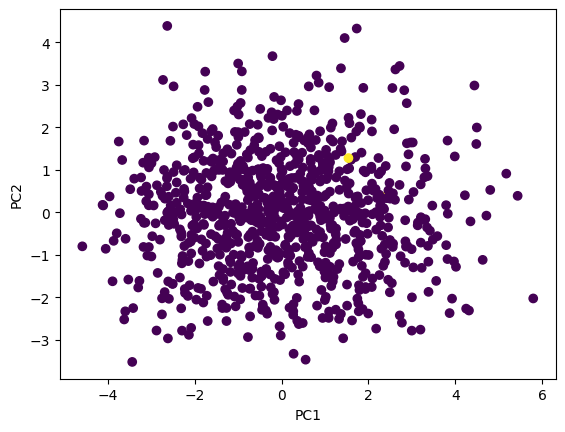

In [15]:
# scatter plot of the first two principal components
plt.scatter(pca_features[:,0], pca_features[:,1], c=clusters, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [16]:
df_clustered = df_numerical.copy()
df_clustered['Cluster'] = clusters

In [17]:
# Calcular las propiedades de cada cluster (media de las variables)
cluster_grouped = df_clustered.groupby('Cluster')
cluster_properties = cluster_grouped.mean()

# Imprimir las propiedades de cada cluster
print(cluster_properties)

               age        jspe   qcae_cog  qcae_aff       amsp  erec_mean  \
Cluster                                                                     
0        22.364253  106.377828  58.536199  34.79638  23.165158   0.720373   
1        31.000000  105.000000  54.000000  29.50000  16.500000   0.619048   

              cesd     stai_t     mbi_ex     mbi_cy     mbi_ea  
Cluster                                                         
0        17.997738  42.849548  16.871041  10.069005  24.202489  
1        41.500000  64.500000  20.000000  14.500000  26.500000  


In [18]:
# Getting the number of patients in each cluster
cluster_grouped.size()

Cluster
0    884
1      2
dtype: int64

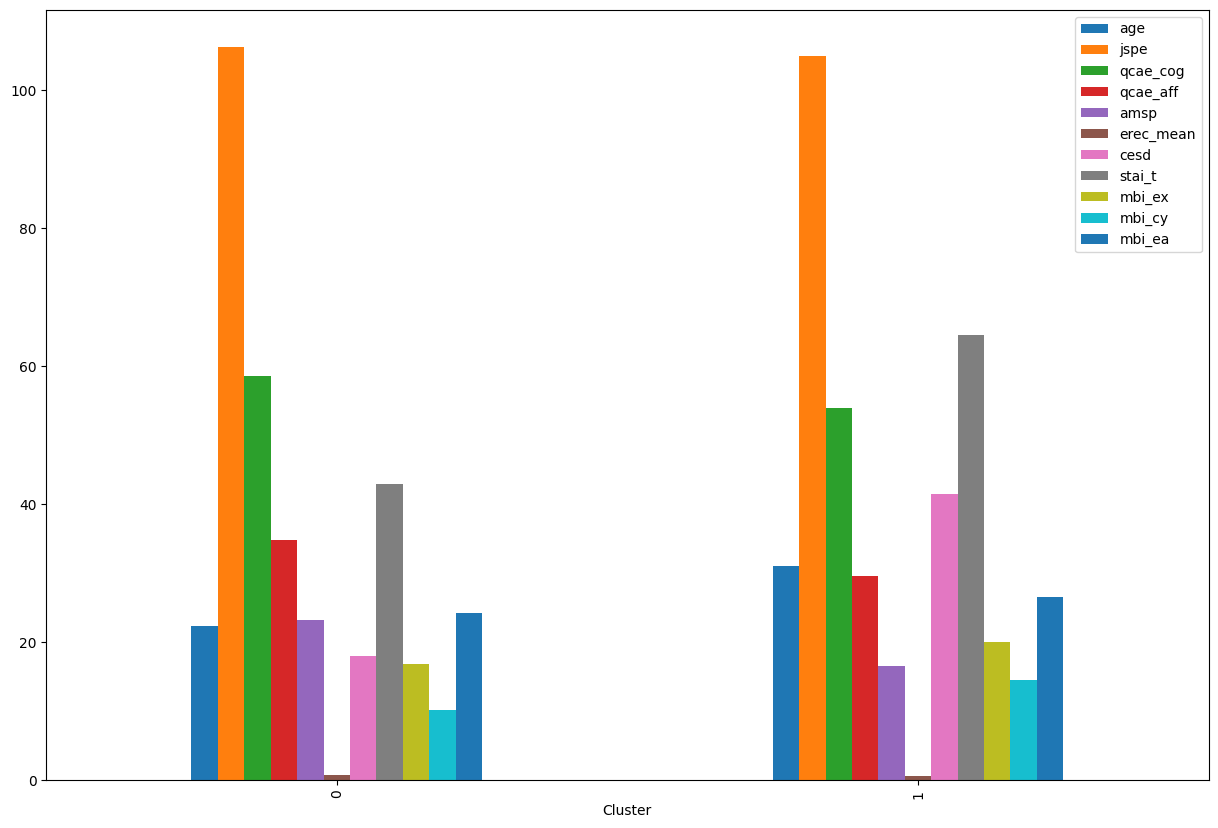

In [19]:
cluster_properties.plot(kind='bar', figsize=(15, 10))
plt.show()

## Conclusions

Com podem observar, els dos clústers mostren característiques semblants. El que es diferencien són les escales de stai_t, cesd, age on són majors al clúster 1 i qcae_aff, amsp on són majors al clúster 0

## Machine Learning

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(pca_features, clusters, test_size=0.2, random_state=42)

# Create a logistic regression classifier
logreg = LogisticRegression(random_state=42)

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.9943820224719101


## Avaluació Model

In [23]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [24]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[177   0]
 [  1   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       177
           1       0.00      0.00      0.00         1

    accuracy                           0.99       178
   macro avg       0.50      0.50      0.50       178
weighted avg       0.99      0.99      0.99       178



c:\Users\LAURA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\LAURA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\LAURA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# Utilització stud_h com a numéric

In [2]:
import pandas as pd

In [3]:
# Lectura fitxer 
df_students = pd.read_csv("datasets/Data Carrard.csv")
df_students = df_students.drop('id', axis = 1)

df_categorical = df_students[['sex', 'year', 'glang', 'part', 'job', 'health', 'psyt']]
df_numerical = df_students[['age', 'stud_h', 'jspe', 'qcae_cog', 'qcae_aff', 'amsp', 'erec_mean', 'cesd', 'stai_t', 'mbi_ex', 'mbi_cy', 'mbi_ea']]

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
df_num_scaled = scaler.fit_transform(df_numerical)

# Create a PCA instance: pca
pca = PCA(n_components=0.95)

# Fit the PCA instance to the scaled samples
pca.fit(df_num_scaled)

# Transform the scaled samples: pca_features
pca_features = pca.transform(df_num_scaled)

## Aplicació Model

In [5]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
n_clusters = 3  # Ajustar el número deseado de clusters
model_sc = SpectralClustering(n_clusters=n_clusters, random_state=42)
clusters = model_sc.fit_predict(pca_features)

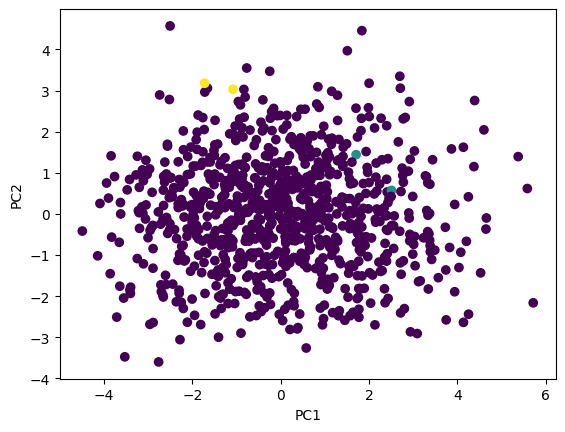

In [7]:
# scatter plot of the first two principal components
plt.scatter(pca_features[:,0], pca_features[:,1], c=clusters, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [9]:
# Agregar las etiquetas de clusters al DataFrame original
df_clustered = df_numerical.copy()
df_clustered['Cluster'] = clusters

In [10]:
# Calcular las propiedades de cada cluster (media de las variables)
cluster_grouped = df_clustered.groupby('Cluster')
cluster_properties = cluster_grouped.mean()

# Imprimir las propiedades de cada cluster
print(cluster_properties)

              age     stud_h        jspe  qcae_cog   qcae_aff       amsp  \
Cluster                                                                    
0        22.35941  25.226757  106.429705  58.56576  34.819728  23.163265   
1        31.00000  58.000000  105.000000  54.00000  29.500000  16.500000   
2        24.50000  20.000000   83.500000  45.50000  24.500000  24.000000   

         erec_mean      cesd     stai_t     mbi_ex     mbi_cy     mbi_ea  
Cluster                                                                   
0         0.720441  18.02381  42.878685  16.891156  10.058957  24.205215  
1         0.619048  41.50000  64.500000  20.000000  14.500000  26.500000  
2         0.690476   6.50000  30.000000   8.000000  14.500000  23.000000  


In [11]:
# Imprimir el número de elementos en cada cluster
print("Número de elementos en cada cluster:")
print(cluster_grouped.size())

Número de elementos en cada cluster:
Cluster
0    882
1      2
2      2
dtype: int64


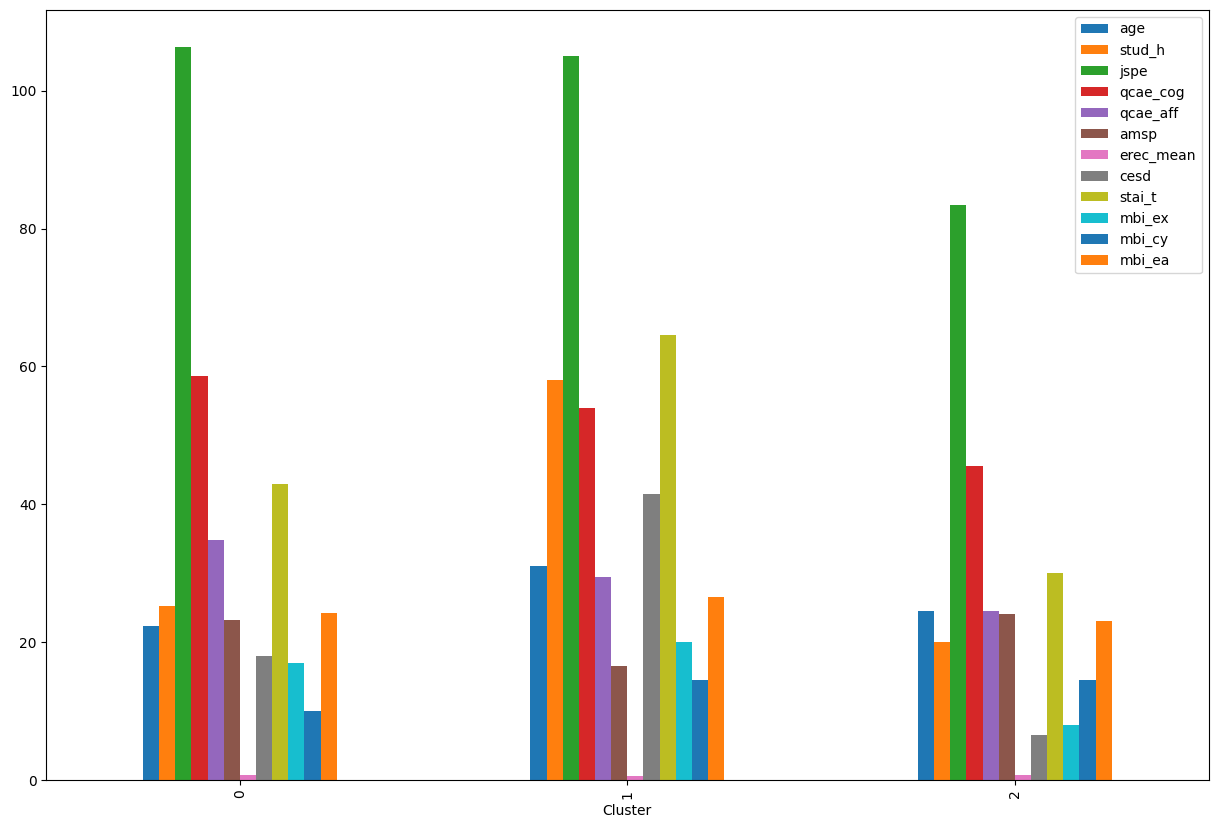

In [12]:
cluster_properties.plot(kind='bar', figsize=(15, 10))
plt.show()

## Conclusions

Podem observar un altre cop que els clústers tenen valors molt semblants. Podem observar però, que els clústers 0 i 1 tendeixen a tenir més empatía (jspe) que el 2. així com el clúster 1 tendeix a tenir més hores de estudi (stud_h) i més depressió (cesd) que el clúster 0 i 2 

## Machine Learning

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(pca_features, clusters, test_size=0.2, random_state=42)

# Create a logistic regression classifier
logreg = LogisticRegression(random_state=42)

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.9943820224719101


## Avaluació Model

In [14]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [15]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[177   0]
 [  1   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       177
           1       0.00      0.00      0.00         1

    accuracy                           0.99       178
   macro avg       0.50      0.50      0.50       178
weighted avg       0.99      0.99      0.99       178



c:\Users\LAURA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\LAURA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\LAURA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo